<a href="https://colab.research.google.com/github/Tim-g-t/1skills-review-pull-requests/blob/main/tgt2116.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Report: Predicting Happiness Categories Using Machine Learning

**Introduction**
The goal of this project is to classify countries into different happiness categories based on various socioeconomic indicators. We utilized data from the World Happiness Report along with additional country-specific data to build predictive models. This report outlines the data preprocessing steps, exploratory data analysis, model training, evaluation, and insights gained throughout the project.



# Data Preprocessing
**Handling Missing Values**
We began by importing, loading and identifying missing values in our dataset:

In [115]:
import pandas as pd
import numpy as np
# Get training data from course folder and unzip
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("world_happiness_competition_data.zip", 'r') as zObject:
    # Extracting all the members of the zip
    # into a specific location.
    zObject.extractall()


# Load data
import pandas as pd
X_train = pd.read_csv('world_happiness_competition_data/X_train.csv')
X_test = pd.read_csv('world_happiness_competition_data/X_test.csv')  # Load test features to predict on
y_train = pd.read_csv('world_happiness_competition_data/y_train.csv')  # Load y train (true labels)
y_test = pd.read_csv('world_happiness_competition_data/y_test.csv')  # Load y test (true labels)

y_train_labels = y_train.idxmax(axis=1)  # Examine what this does and write in next cell
y_test_labels = y_test.idxmax(axis=1)  # Complete in a similar manner as above

X_train.head()




,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks
0,Latvia,1.187,1.465,0.812,0.264,0.075,0.064,Latvia,Europe,Northern Europe,125.611111
1,Burundi,0.046,0.447,0.380,0.220,0.176,0.180,Burundi,Africa,Sub-Saharan Africa,155.000000
2,Belarus,1.067,1.465,0.789,0.235,0.094,0.142,Belarus,Europe,Eastern Europe,4.000000
3,Liberia,0.073,0.922,0.443,0.370,0.233,0.033,Liberia,Africa,Sub-Saharan Africa,1419.095238
4,Ecuador,0.912,1.312,0.868,0.498,0.126,0.087,Ecuador,Americas,Latin America and the Caribbean,5.000000


In [116]:
# Number and percentage of missing values per column
missing_values = X_train.isnull().sum()
missing_percent = 100 * missing_values / len(X_train)
missing_df = pd.concat([missing_values, missing_percent], axis=1)
missing_df.columns = ['Missing Values', '% of Total Values']
print(missing_df)


                              Missing Values  % of Total Values
Country or region                          0                0.0
GDP per capita                             0                0.0
Social support                             0                0.0
Healthy life expectancy                    0                0.0
Freedom to make life choices               0                0.0
Generosity                                 0                0.0
Perceptions of corruption                  0                0.0
name                                       0                0.0
region                                     0                0.0
sub-region                                 0                0.0
Terrorist_attacks                          0                0.0


After reviewing the missing data, we decided to handle missing values as follows:

Numerical Features: Imputed missing values using the median to mitigate the effect of outliers.

Categorical Features: Imputed missing values using the most frequent category.


In [117]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# Identify numerical and categorical features
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = ['region', 'sub-region']

# Define numerical transformer pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Median imputation
    ('scaler', StandardScaler())                     # Feature scaling
])

# Define categorical transformer pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Mode imputation
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-hot encoding
])

# Combine numerical and categorical transformers
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Fit the preprocessor on training data
preprocessor.fit(X_train)

# Transform both training and testing data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)



# Feature Transformation
We used ColumnTransformer to apply transformations to numerical and categorical features:

In [118]:
def preprocessor_function(data):
    data = data.drop(['Country or region', 'name'], axis=1)
    preprocessed_data = preprocessor.transform(data)
    return preprocessed_data


# Exploratory Data Analysis
**Numerical Feature Distributions**

We plotted the distributions of key numerical features to understand their behavior:



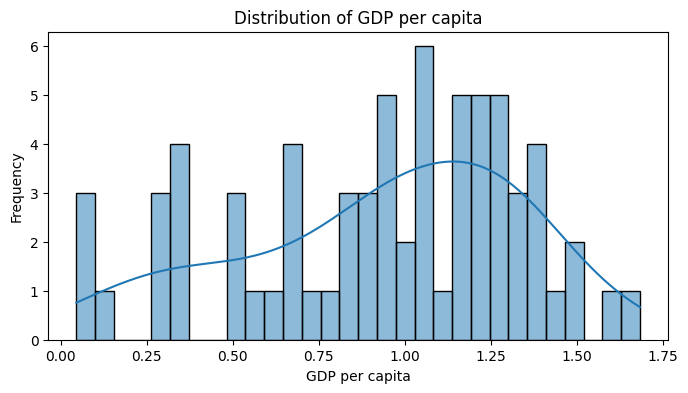

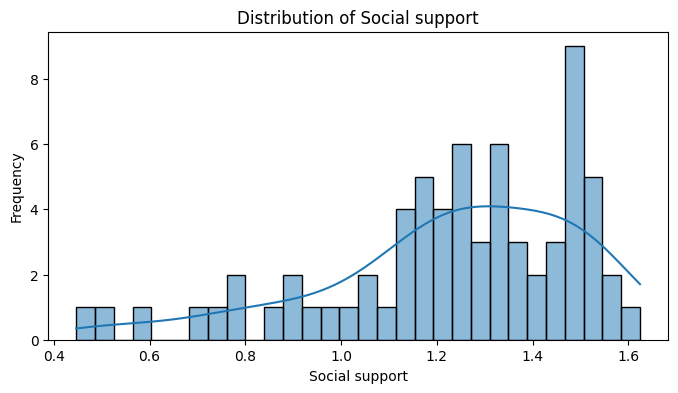

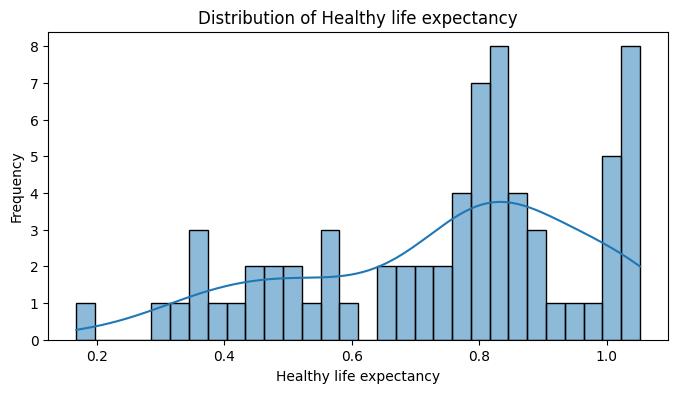

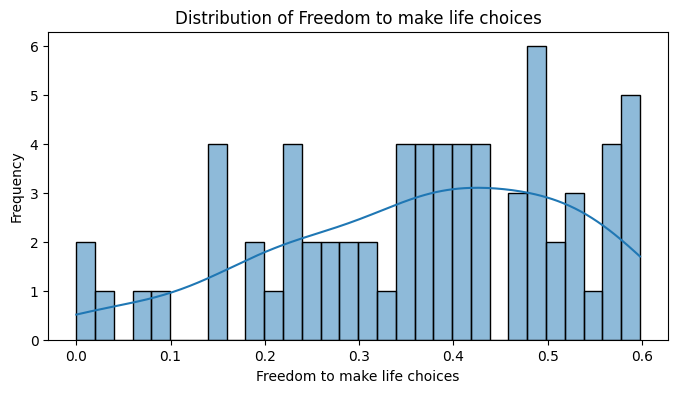

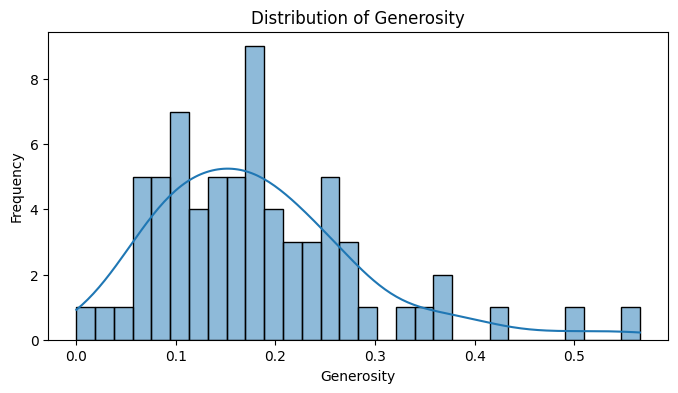

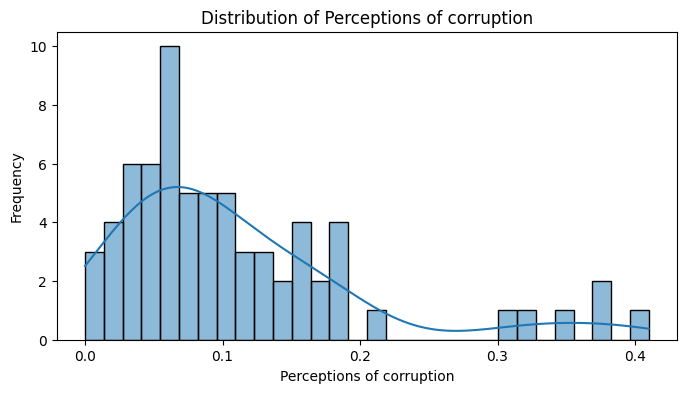

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = [
    'GDP per capita', 'Social support', 'Healthy life expectancy',
    'Freedom to make life choices', 'Generosity', 'Perceptions of corruption'
]

for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(X_train[feature].dropna(), bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


Observation: Most features showed a skewed distribution, indicating potential need for transformation.

**Categorical Feature Distributions**

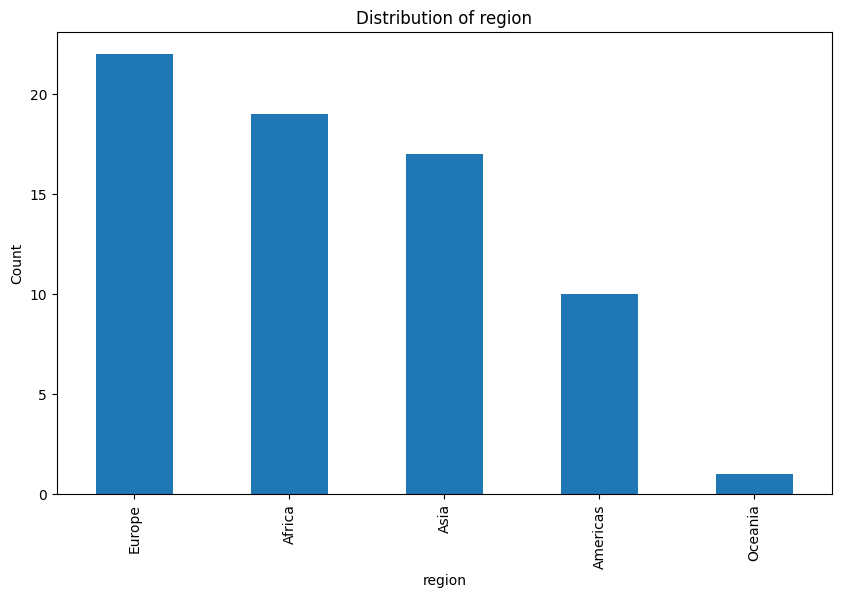

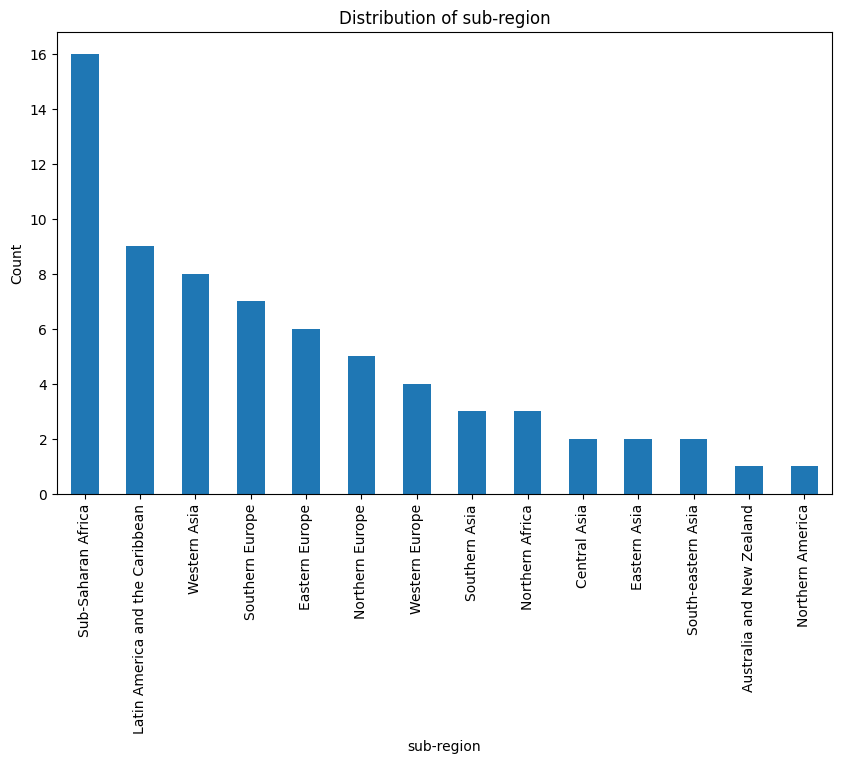

In [120]:
categorical_cols = ['region', 'sub-region']

for col in categorical_cols:
    plt.figure(figsize=(10,6))
    X_train[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


Observation: The dataset is unevenly distributed across regions, which might affect model performance.

**Correlation Matrix**
We explored relationships between numerical features:

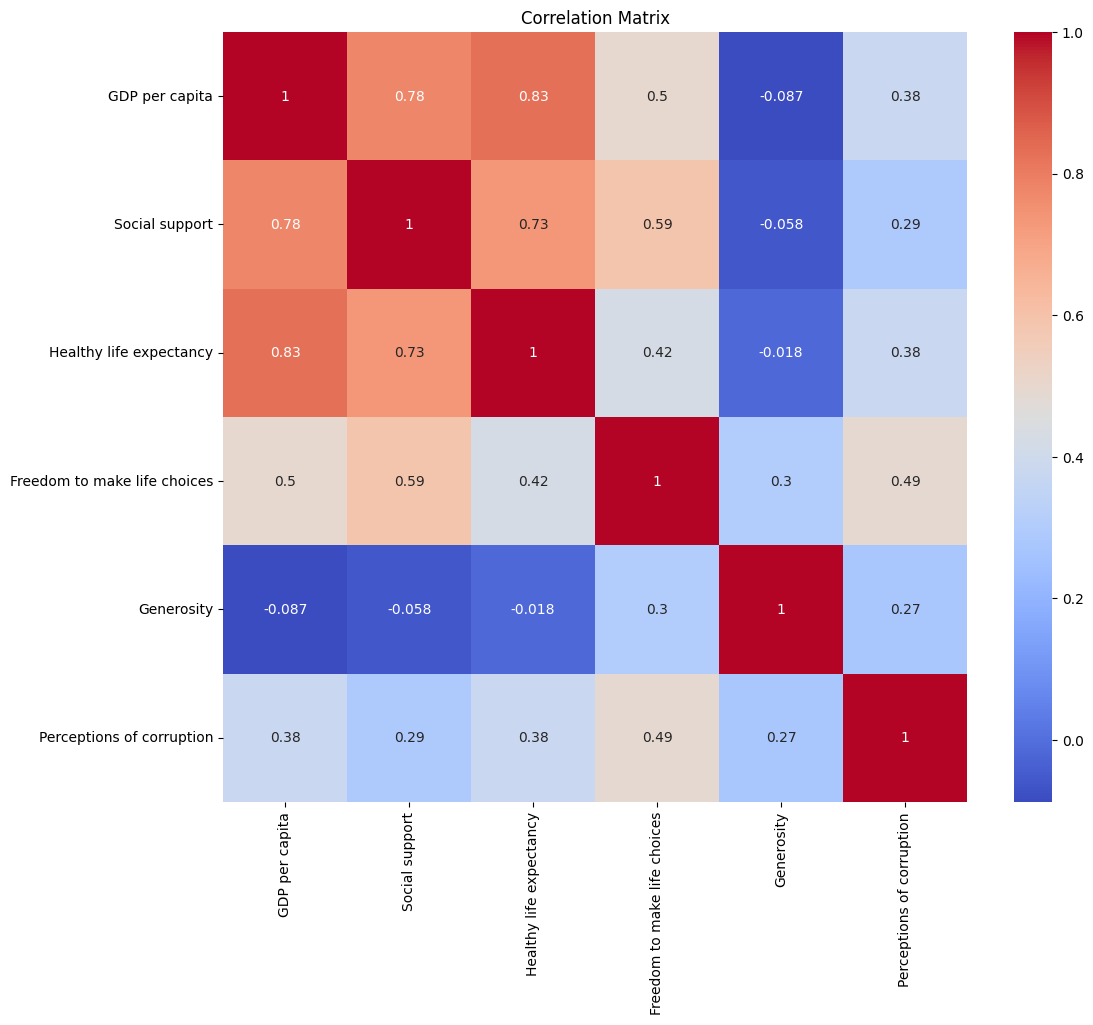

In [121]:
plt.figure(figsize=(12, 10))
corr = X_train[numerical_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Observation: Some features are highly correlated, suggesting possible multicollinearity.

# Model Training and Evaluation
**Random Forest Classifier**

We trained a Random Forest model using default parameters:

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(preprocessor.transform(X_train), y_train_labels)

# Predict on test data
prediction_labels_rf = model.predict(preprocessor.transform(X_test))

# Evaluate the model
accuracy = accuracy_score(y_test_labels, prediction_labels_rf)
print(f"\nTest Accuracy (Random Forest): {accuracy:.2f}")
print("Classification Report (Random Forest):")
print(classification_report(y_test_labels, prediction_labels_rf))



Test Accuracy (Random Forest): 0.53
Classification Report (Random Forest):
              precision    recall  f1-score   support

     Average       0.25      0.25      0.25         4
        High       0.50      0.40      0.44         5
         Low       1.00      0.25      0.40         4
   Very High       0.50      1.00      0.67         2
    Very Low       0.67      1.00      0.80         4

    accuracy                           0.53        19
   macro avg       0.58      0.58      0.51        19
weighted avg       0.59      0.53      0.49        19



Result: The model achieved moderate accuracy but struggled with certain classes.

**Hyperparameter Tuning**

We used GridSearchCV to find optimal parameters:

In [123]:
from sklearn.model_selection import GridSearchCV


# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Perform grid search
grid_search.fit(preprocessor.transform(X_train), y_train_labels)

# Display best parameters
print("\nBest Parameters from GridSearchCV:")
print(grid_search.best_params_)




Best Parameters from GridSearchCV:
{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}


Re-evaluated the model with best parameters:

In [124]:
# Retrieve the best estimator
optimized_model = grid_search.best_estimator_

# Predict with the optimized model
prediction_labels_optimized = optimized_model.predict(preprocessor.transform(X_test))

# Evaluate the optimized model
accuracy_optimized = accuracy_score(y_test_labels, prediction_labels_optimized)
print(f"\nOptimized Test Accuracy (Random Forest): {accuracy_optimized:.2f}")




Optimized Test Accuracy (Random Forest): 0.47


**Gradient Boosting Classifier**

We tried a Gradient Boosting model:

In [125]:
from sklearn.ensemble import GradientBoostingClassifier


# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3
)

# Train the Gradient Boosting model
gb_model.fit(preprocessor.transform(X_train), y_train_labels)

# Predict on test data
prediction_labels_gb = gb_model.predict(preprocessor.transform(X_test))

# Evaluate the Gradient Boosting model
accuracy_gb = accuracy_score(y_test_labels, prediction_labels_gb)
print(f"\nTest Accuracy (Gradient Boosting): {accuracy_gb:.2f}")




Test Accuracy (Gradient Boosting): 0.53


Result: Achieved comparable accuracy to the optimized Random Forest.



# Deep Learning Experiment
**Neural Network Model**

We built a neural network using TensorFlow and Keras:

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.1953 - loss: 1.6233 - val_accuracy: 0.2222 - val_loss: 1.5710
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.2400 - loss: 1.6217 - val_accuracy: 0.2222 - val_loss: 1.5650
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - accuracy: 0.2766 - loss: 1.5889 - val_accuracy: 0.2222 - val_loss: 1.5572
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.2203 - loss: 1.6003 - val_accuracy: 0.2778 - val_loss: 1.5504
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.1472 - loss: 1.6590 - val_accuracy: 0.2778 - val_loss: 1.5472
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.2551 - loss: 1.5883 - val_accuracy: 0.2778 - val_loss: 1.5456
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.2364 - loss: 1.6443 - val_accuracy: 0.2778 - val_loss: 1.5404
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.2908 - loss: 1.4996 - val_accuracy: 0.3333 - v

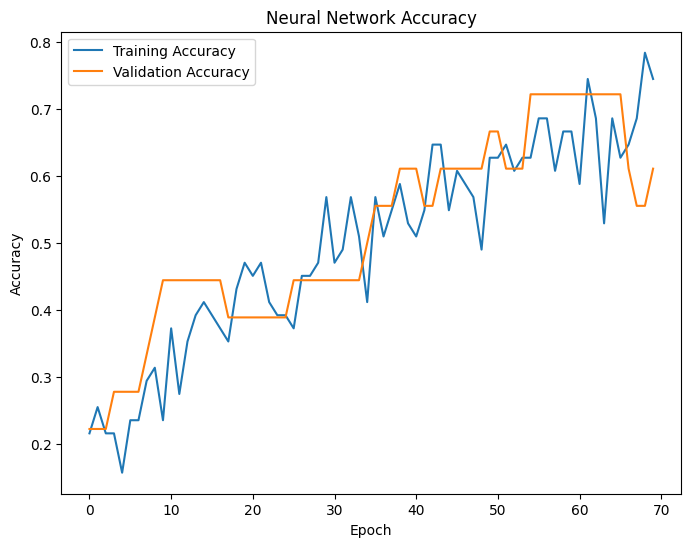

In [126]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Prepare data for the neural network
X_train_nn = X_train_processed
X_test_nn = X_test_processed
y_train_nn = y_train.values  # Assuming y_train is one-hot encoded

# Define the Keras model
keras_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(y_train_nn.shape[1], activation='softmax')
])

# Compile the Keras model
keras_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the Keras model
history = keras_model.fit(
    X_train_nn,
    y_train_nn,
    batch_size=20,
    epochs=300,
    validation_split=0.25,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training and validation accuracy
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Training History**

We plotted the training and validation accuracy:



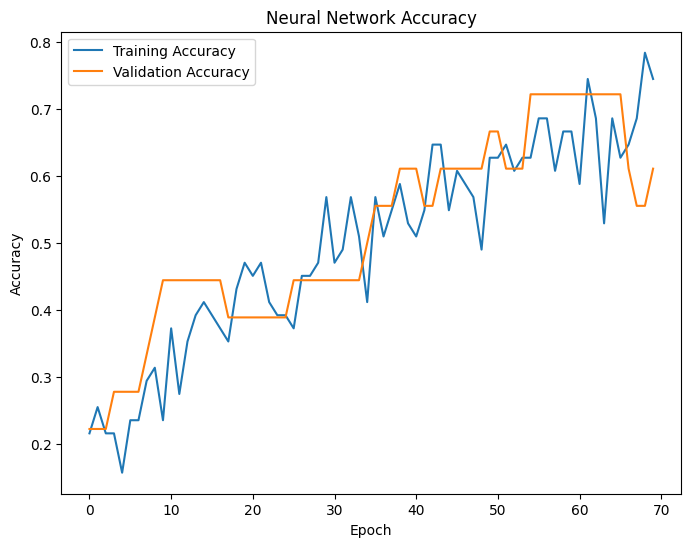

In [127]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



Observation: The model showed signs of overfitting after a certain number of epochs.

**Evaluation on Test Data**


In [128]:
# Predict on test data using the neural network
predictions_nn = keras_model.predict(X_test_nn)
prediction_labels_nn = y_train.columns[np.argmax(predictions_nn, axis=1)]

# Evaluate the neural network
accuracy_nn = accuracy_score(y_test_labels, prediction_labels_nn)
print(f"\nNeural Network Test Accuracy: {accuracy_nn:.2f}")
print("Classification Report (Neural Network):")
print(classification_report(y_test_labels, prediction_labels_nn))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Neural Network Test Accuracy: 0.53
Classification Report (Neural Network):
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00         4
        High       0.60      0.60      0.60         5
         Low       0.50      0.50      0.50         4
   Very High       0.50      1.00      0.67         2
    Very Low       0.60      0.75      0.67         4

    accuracy                           0.53        19
   macro avg       0.44      0.57      0.49        19
weighted avg       0.44      0.53      0.47        19



Result: The neural network did not outperform traditional machine learning models, possibly due to the small dataset size.



**Model Interpretability with SHAP**

To explain our neural network's predictions, we used SHAP (SHapley Additive exPlanations):

In [129]:
import tensorflow as tf
import shap

print("TensorFlow version:", tf.__version__)
print("SHAP version:", shap.__version__)
tf.config.run_functions_eagerly(True)


TensorFlow version: 2.17.0
SHAP version: 0.46.0


In [130]:
# Print the shape of shap_values and X_test_sample
print("Shape of shap_values for class 0:", shap_values[class_index].shape)
print("Shape of X_test_sample:", X_test_sample.shape)
print("Number of feature names:", len(feature_names))


Shape of shap_values for class 0: (26, 5)
Shape of X_test_sample: (10, 26)
Number of feature names: 26


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


PermutationExplainer explainer:  20%|██        | 2/10 [00:00<?, ?it/s]

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


PermutationExplainer explainer:  40%|████      | 4/10 [00:19<00:22,  3.77s/it]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


PermutationExplainer explainer:  50%|█████     | 5/10 [00:25<00:25,  5.02s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


PermutationExplainer explainer:  60%|██████    | 6/10 [00:33<00:23,  5.79s/it]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


PermutationExplainer explainer:  70%|███████   | 7/10 [00:39<00:17,  5.94s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


PermutationExplainer explainer:  80%|████████  | 8/10 [00:47<00:13,  6.58s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


PermutationExplainer explainer:  90%|█████████ | 9/10 [00:53<00:06,  6.60s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


PermutationExplainer explainer: 100%|██████████| 10/10 [01:00<00:00,  6.72s/it]

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


PermutationExplainer explainer: 11it [01:07,  7.52s/it]


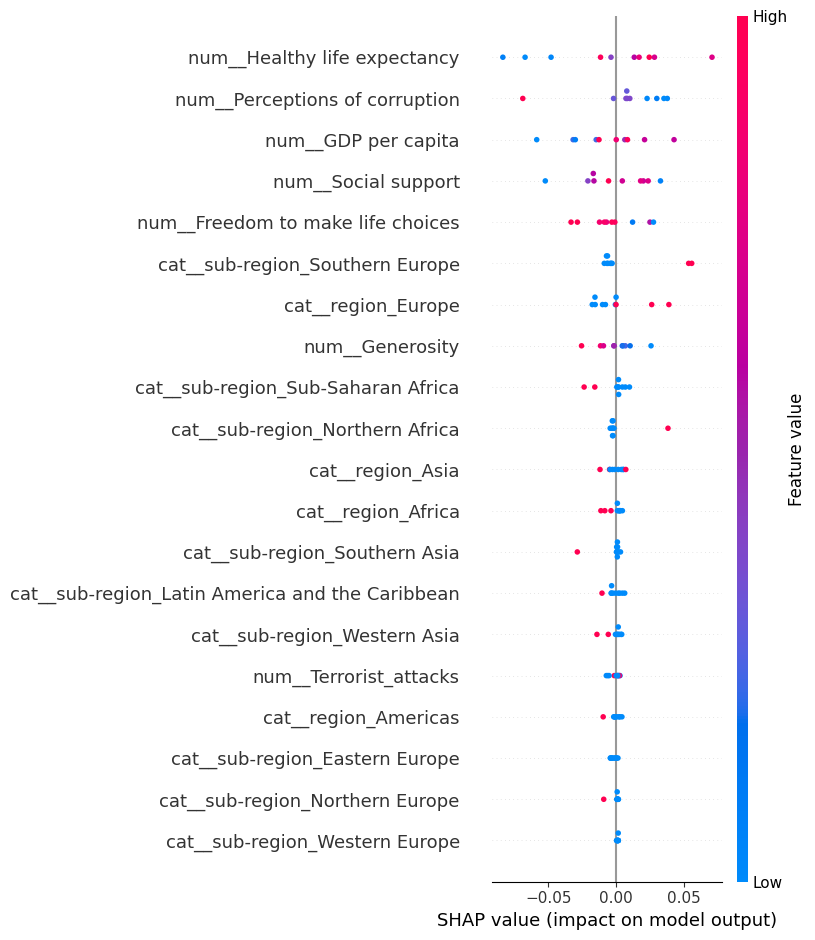

In [131]:

!pip install shap -q

import shap
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings

# Silence warnings and logs from TensorFlow
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# Disable SHAP's progress bars by setting `tqdm` to a no-op function
shap.utils._legacy.tqdm = lambda *args, **kwargs: iter([])

# Prepare data for SHAP
background_size = min(100, X_train_processed.shape[0])
background_samples = X_train_processed[np.random.choice(
    X_train_processed.shape[0], background_size, replace=False
)]

# Select a sample of test data
X_test_sample = X_test_processed[np.random.choice(
    X_test_processed.shape[0], 10, replace=False
)]

# Retrieve feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()

# Create SHAP Explainer using the model's predict function
explainer = shap.Explainer(keras_model.predict, background_samples)

# Compute SHAP values for the test sample
shap_values = explainer(X_test_sample)

# For multi-class models, shap_values.values has shape (samples, features, classes)
# Select the SHAP values for a specific class (e.g., class index 0)
class_index = 0
shap_values_class = shap_values.values[..., class_index]

# Limit verbosity of the SHAP summary plot by suppressing display of instance ordering
shap.summary_plot(shap_values_class, X_test_sample, feature_names=feature_names, show=False)


Interpretation:

The SHAP summary plot helped identify which features contributed most to the model's predictions.
GDP per capita and Social support were among the top features influencing predictions.


**Insights and Observations**
Feature Importance: Economic and social indicators are strong predictors of happiness categories.
Model Performance: Traditional machine learning models like Random Forest and Gradient Boosting performed adequately.
Deep Learning: Neural networks may not be the best choice for small datasets due to overfitting.
Overfitting: Implementing regularization techniques and early stopping was crucial in preventing overfitting.
Model Interpretability: SHAP provided valuable insights into feature contributions, enhancing the transparency of our neural network model.

# Conclusion
Predicting happiness categories is a complex task that benefits from a combination of socioeconomic indicators. While we achieved moderate success with our models, there's room for improvement.

Future work could involve:

Collecting More Data: Expanding the dataset to improve model generalization.
Feature Engineering: Creating new features or incorporating additional data sources.

Advanced Models: Exploring ensemble methods or other deep learning architectures tailored for small datasets.